In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from src.data_utils import *        
from src.models import UNet
from src.train_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"

time_start = "2017-01-01"
time_end = "2022-12-31"

zarr_ds = load_data(data_dir, time_start=time_start, time_end=time_end)

In [3]:
batch_size = 32
train_loader, test_loader = get_data_loaders(zarr_ds, 0.8, batch_size=batch_size)

In [4]:
def advection_diffusion(c, u, v, D, dx, dy):
    # Simplified 2D advection-diffusion equation
    # dc/dt = -u * dc/dx - v * dc/dy + D * (d^2c/dx^2 + d^2c/dy^2)
    dc_dx = torch.gradient(c, dim=1)[0] / (2 * dx)
    dc_dy = torch.gradient(c, dim=2)[0] / (2 * dy)
    d2c_dx2 = torch.gradient(dc_dx, dim=1)[0] / (dx**2)
    d2c_dy2 = torch.gradient(dc_dy, dim=2)[0] / (dy**2)

    return -u * dc_dx - v * dc_dy + D * (d2c_dx2 + d2c_dy2)

In [6]:
class ConvChlorophyllPINN(nn.Module):
    def __init__(self, input_channels, hidden_channels=32):
        super(ConvChlorophyllPINN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.output_layer = nn.Conv2d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        features = self.conv_layers(x)
        return F.relu(self.output_layer(features))

In [13]:
def train_epoch(model, optimizer, criterion, train_loader, device, lambda_phys=0.1):
    model.train()
    rec_losses, phys_losses = [], []
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, targets in pbar:
        x, y = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x).squeeze()
        rec_loss = criterion(outputs, y)
        pred_dc_dt = advection_diffusion(
            outputs.squeeze(), x[:, 7, :, :], x[:, 8, :, :], D, dx, dy
        )
        loss_physics = (pred_dc_dt**2).mean()
        loss = rec_loss + lambda_phys * loss_physics
        loss.backward()
        optimizer.step()
        rec_losses.append(rec_loss.item())
        phys_losses.append(loss_physics.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        pbar.set_postfix(
            {
                "Loss": f"{loss.item():.4f}",
                "rec. loss": f"{rec_loss.item():.4f}",
                "phys. loss": f"{loss_physics.item():.4f}",
            }
        )
    # Close the progress bar
    pbar.close()
    # Return average loss for the epoch
    return rec_losses, phys_losses


def validate(model, criterion, val_loader, device, lambda_phys=0.1):
    model.eval()
    total_loss, physics_loss = 0.0, 0.0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for inputs, targets in pbar:
            x, y = inputs.to(device), targets.to(device)
            outputs = model(x).squeeze()
            rec_loss = criterion(outputs, y)
            pred_dc_dt = advection_diffusion(
                outputs.squeeze(), x[:, 7, :, :], x[:, 8, :, :], D, dx, dy
            )
            loss_physics = (pred_dc_dt**2).mean()
            loss = rec_loss + lambda_phys * loss_physics
            total_loss += loss.item()
            physics_loss += loss_physics.item()
            pbar.set_postfix(
                {
                    "Loss": f"{loss.item():.4f}",
                    "rec. loss": f"{rec_loss.item():.4f}",
                    "phys. loss": f"{loss_physics.item():.4f}",
                }
            )

        pbar.close()

    return total_loss / len(val_loader), physics_loss / len(val_loader)


from src.plotting_utils import plot_output


def get_output(model, x):
    model.eval()
    with torch.no_grad():
        inputs = x.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()

    return outputs


def train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    num_epochs=100,
    scheduler=None,
    lambda_physics=0.1,
    show_every=10,
    plot_every=False,
):
    model.train()
    my_x, my_y = next(iter(val_loader))
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        train_loss, phys_loss = train_epoch(
            model,
            optimizer,
            criterion,
            train_loader,
            device,
            lambda_phys=lambda_physics,
        )
        val_loss, val_phys = validate(
            model, criterion, val_loader, device, lambda_phys=lambda_physics
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if (epoch + 1) % show_every == 0:

            train_loss_mn = np.mean(train_loss)
            print(
                f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_mn:.4f}, Val Loss: {val_loss:.4f}, Val phys. Loss: {val_phys:.4f}"
            )
            if plot_every:
                output = get_output(model, my_x)
                plot_output(output, my_x, my_y, batch_ind=0, figsize=(10, 10))

        if scheduler is not None:
            scheduler.step(val_loss)
    return train_losses, val_losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [16]:
D = 1e-4
dx = (zarr_ds.lon[1] - zarr_ds.lon[0]).values
dy = (zarr_ds.lat[0] - zarr_ds.lat[1]).values

In [99]:
model = None

In [98]:
torch.save(model.cpu(), "../saved_models/chl_conv_pinn_v0.pt")

In [102]:
model = torch.load("../saved_models/chl_conv_pinn_v0.pt").to(device)

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)

model = ConvChlorophyllPINN(input_channels=9).to(device)
model.compile()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.8, patience=5)
lambda_phys = 0.1

In [ ]:
n_epochs = 150
train_losses, test_losses = train(
    model,
    opt,
    criterion,
    train_loader,
    test_loader,
    device,
    num_epochs=n_epochs,
    lambda_physics=lambda_phys,
    scheduler=scheduler,
    show_every=25,
    plot_every=True,
)

In [94]:
def stack_array(x, m, n):
    b, h, w = x.shape
    N = m * n
    x_ = x[:N, :, :]
    ids = np.array_split(np.arange(N), m)
    tmp = np.zeros((m, n * h, w))
    for i, id in enumerate(ids):
        xx = x_[id, :, :].reshape(1, n * h, w)
        tmp[i, :, :] = xx

    return np.hstack([tmp[i, :, :] for i in range(m)])


def plot_output_grid(x, y, output, m, n, figsize=(10, 14)):
    stacked_x = stack_array(x[:, 0, :, :], m, n)
    stacked_y = stack_array(y, m, n)
    stacked_output = stack_array(output, m, n)
    res = stacked_y - stacked_output
    arrays = [stacked_y, stacked_output, res, stacked_x]
    labels = ["Target", "Prediction", "Residual", "Input"]

    fig, axs = plt.subplots(2, 2, figsize=figsize)
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(arrays[i], clim=(0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[i])

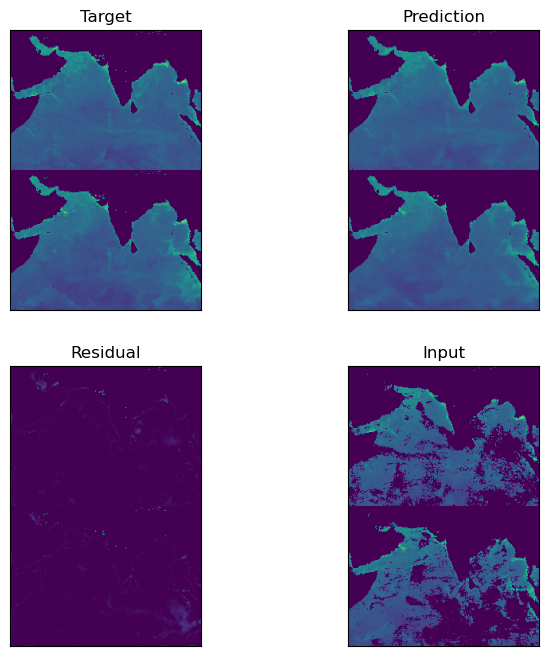

In [103]:
x, y = next(iter(test_loader))
output = get_output(model, x)
plot_output_grid(x, y, output, 1, 2, figsize=(8, 8))

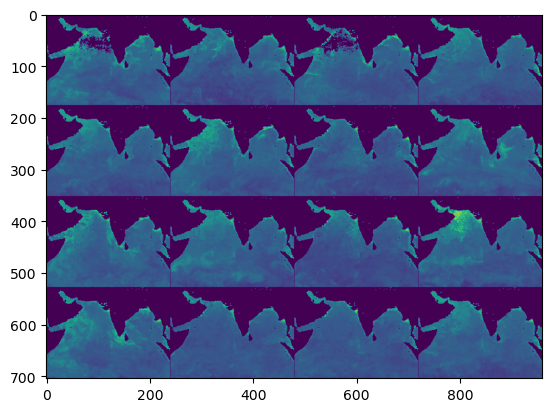

In [68]:
q = plot_array(y, 4, 4)
plt.imshow(q)

In [48]:
q = [tmp[i, :, :] for i in range(6)]

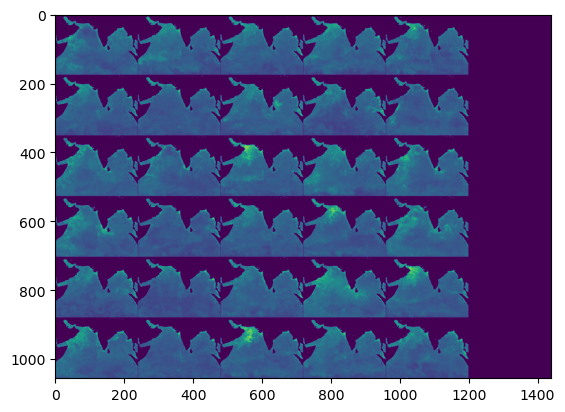

In [52]:
plt.imshow(np.hstack(q))

In [13]:
from src.plotting_utils import plot_output


def get_output(model, x):
    model.eval()
    with torch.no_grad():
        inputs = x.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()

    return outputs

In [14]:
x, y = next(iter(test_loader))
outputs = get_output(model, x)

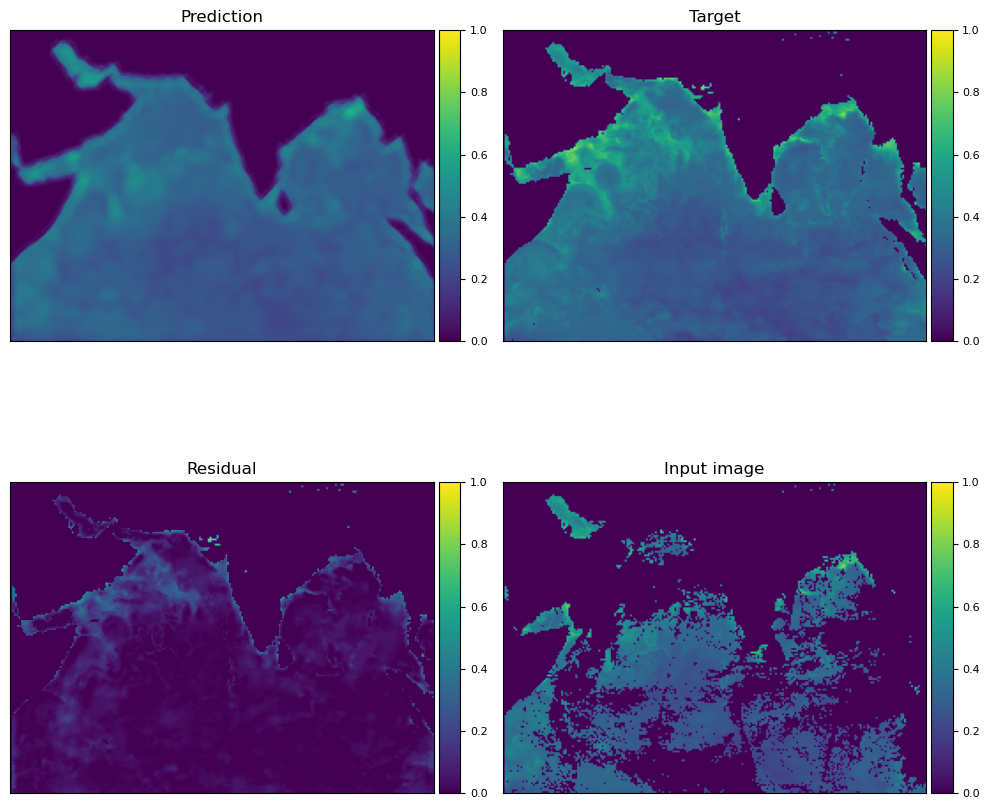

In [17]:
plot_output(outputs, x, y, batch_ind=0, figsize=(10, 10))

In [109]:
def sample_sensors(features, num_sensors, seed=None):
    """
    Sample random locations from the image to act as sensors.

    :param features: Input features tensor (batch_size, channels, height, width)
    :param num_sensors: Number of sensor locations to sample
    :param seed: Random seed for reproducibility
    :return: Sampled sensor locations and their corresponding values
    """
    if seed is not None:
        torch.manual_seed(seed)

    batch_size, channels, height, width = features.shape

    # Sample random locations
    locations = torch.randint(0, height * width, (batch_size, num_sensors))
    y_coords = locations // width
    x_coords = locations % width

    # Get values at sampled locations
    idx = (
        torch.arange(batch_size).unsqueeze(1),
        torch.arange(channels).unsqueeze(0).unsqueeze(-1),
        y_coords.unsqueeze(1),
        x_coords.unsqueeze(1),
    )
    sensor_values = features[idx].permute(0, 2, 1)

    # Normalize coordinates to [-1, 1] range
    normalized_coords = torch.stack(
        [
            2 * x_coords.float() / (width - 1) - 1,
            2 * y_coords.float() / (height - 1) - 1,
        ],
        dim=-1,
    )

    return normalized_coords, sensor_values

In [110]:
sample_sensors(x, 100)

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32, 1], [1, 9, 1], [32, 1, 100], [32, 1, 100]

In [126]:
features, target, num_sensors = x, y, 100
batch_size, channels, height, width = features.shape

# Sample random locations
y_coords = torch.randint(0, height, (batch_size, num_sensors))
x_coords = torch.randint(0, width, (batch_size, num_sensors))

# Get values at sampled locations
batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, num_sensors)
sensor_values = target[batch_indices, y_coords, x_coords]

# Normalize coordinates to [-1, 1] range
normalized_coords = torch.stack(
    [2 * x_coords.float() / (width - 1) - 1, 2 * y_coords.float() / (height - 1) - 1],
    dim=-1,
)

In [128]:
sensor_values.shape

torch.Size([32, 100])

In [125]:
y.shape

torch.Size([32, 176, 240])